In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import xoverturning
import matplotlib.pyplot as plt

In [8]:
xr.set_options(display_style="text")

# Conservatively diagnosing model transports into an arbitrary closed region with `sectionate`

## Load example model grid and transport diagnosics

In [9]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'

In [10]:
ocean_grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
ds = xr.open_mfdataset(f"{dir_pp}/ocean_annual_z_d2/av/annual_5yr/*.nc", decode_times=False)
ds = ds.assign_coords({
    'dxCv': xr.DataArray(ocean_grid['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
}) # add velocity face widths to calculate distances along the section
ds = ds.assign_coords({
    'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=("yh", "xh")),
    'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=("yh", "xh")),
    'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=("yq", "xq",)),
    'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=("yq", "xq",)),
    'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=("yh", "xh",)),
})
coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
}
grid = xgcm.Grid(ds, coords=coords, periodic=("X"))

In [11]:
ds

<xarray.Dataset>
Dimensions:                         (xh: 1440, yh: 1120, z_l: 35, z_i: 36,
                                     time: 3, nv: 2, xq: 1441, yq: 1121)
Coordinates: (12/15)
  * xh                              (xh) float64 -298.6 -298.4 ... 60.93 61.16
  * yh                              (yh) float64 -83.62 -83.54 ... 89.81 89.92
  * z_l                             (z_l) float64 2.5 10.0 ... 6e+03 6.5e+03
  * z_i                             (z_i) float64 0.0 5.0 ... 6.25e+03 6.75e+03
  * time                            (time) float64 912.5 2.738e+03 4.562e+03
  * nv                              (nv) float64 1.0 2.0
    ...                              ...
    dyCu                            (xq, yh) float32 7.684e+03 ... 0.04939
    geolon                          (yh, xh) float32 -298.5 -298.2 ... -300.0
    geolat                          (yh, xh) float32 -82.4 -82.4 ... 64.14 64.03
    geolon_c                        (yq, xq) float32 -298.5 -298.3 ... 60.0 60.0
    geolat_c                        (yq, xq) float32 -82.44 -82.44 ... 64.03
    deptho                          (yh, xh) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables: (12/43)
    volcello                        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    thetao                          (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    so                              (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    obvfsq                          (time, z_i, yh, xh) float32 dask.array<chunksize=(1, 36, 1120, 1440), meta=np.ndarray>
    agessc                          (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    uo                              (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 35, 1120, 1441), meta=np.ndarray>
    ...                              ...
    Kd_BBL                          (time, z_i, yh, xh) float32 dask.array<chunksize=(1, 36, 1120, 1440), meta=np.ndarray>
    Kd_ePBL                         (time, z_i, yh, xh) float32 dask.array<chunksize=(1, 36, 1120, 1440), meta=np.ndarray>
    time_bnds                       (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    average_T1                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:             CM4_piControl_c192_OM4p125_test_v6_proto2
    grid_type:         regular
    grid_tile:         N/A
    associated_files:  areacello: ocean_static_d2.nc
    history:           Tue Jul  6 20:17:04 2021: ncatted -O -a associated_fil...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....
    comment:           FMS time averaging, version 3.0, precision=double
    filename:          ocean_annual_z_d2.0001-0005.ann.nc

## Define the two OSNAP sections:

In [12]:
Labrador_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50, -65, -65]
Labrador_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000, 71, 63.5, 57.5]
Labrador_section_lons = np.append(Labrador_section_lons, Labrador_section_lons[0])
Labrador_section_lats = np.append(Labrador_section_lats, Labrador_section_lats[0])

## Closed section surrounding Labrador Sea

Specifying `closed=True` ensures that the end-point is not double-counted

In [13]:
i, j, x, y = sectionate.create_section_composite(
    ds['geolon_c'],
    ds['geolat_c'],
    Labrador_section_lons,
    Labrador_section_lats,
    sectionate.check_symmetric(grid),
    closed=True
)

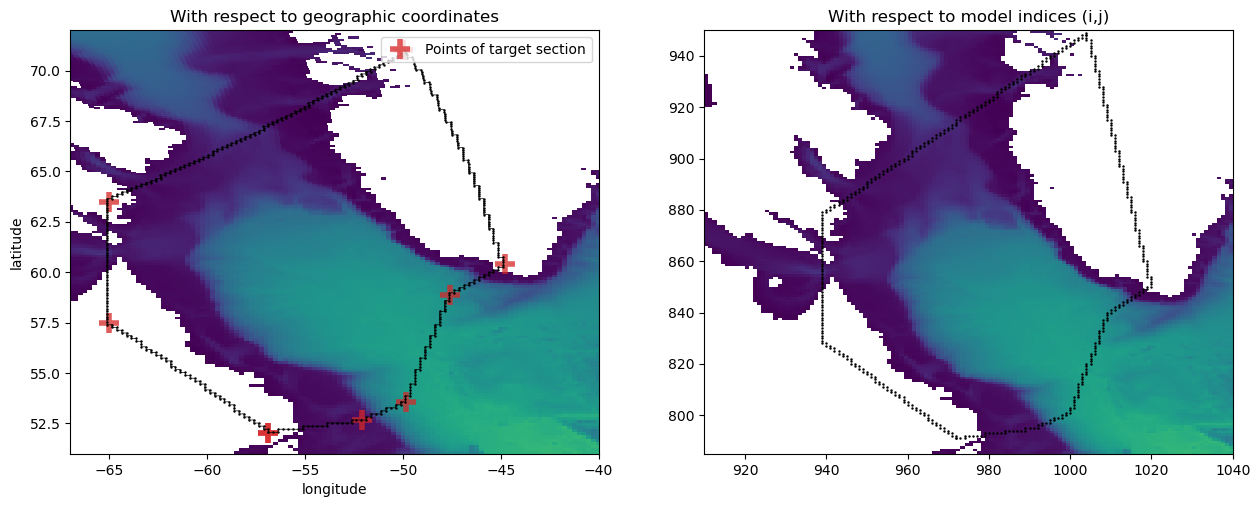

In [14]:
depth_masked = ds['deptho'].where(ds['deptho'] != 0)

plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(ds['geolon_c'], ds['geolat_c'], depth_masked)
plt.plot(Labrador_section_lons, Labrador_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.plot(x, y, 'k.-', markersize=1.5, lw=0.5)
plt.axis([-67,-40, 51, 72])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(depth_masked)
plt.plot(i, j, 'k.', markersize=1.5, lw=0.5)
plt.axis([910, 1040, 785, 950])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [16]:
T = sectionate.extract_tracer(ds['thetao'], grid, i, j)

In [17]:
Trp = sectionate.convergent_transport(ds, grid, i, j, counterclockwise=True)

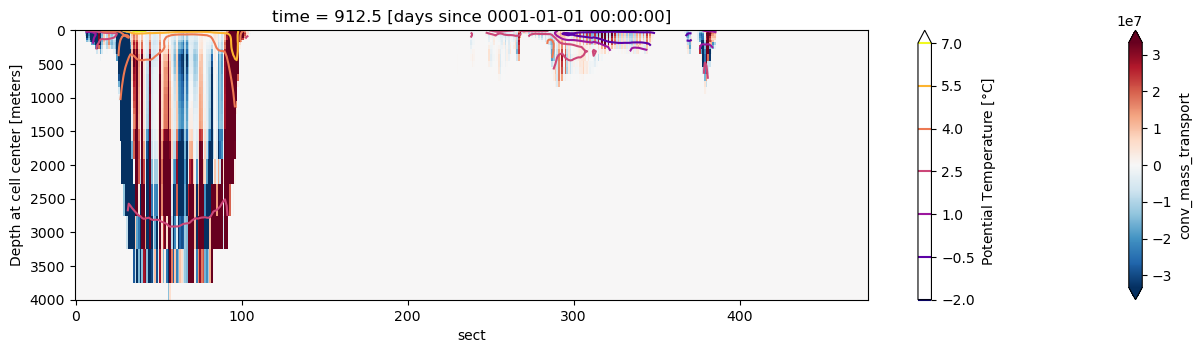

In [18]:
plt.figure(figsize=(16, 3.5))
Trp.isel(time=0)['conv_mass_transport'].plot(cmap='RdBu_r', yincrease=False, ylim=[4000,0], robust=True)
cs = T.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

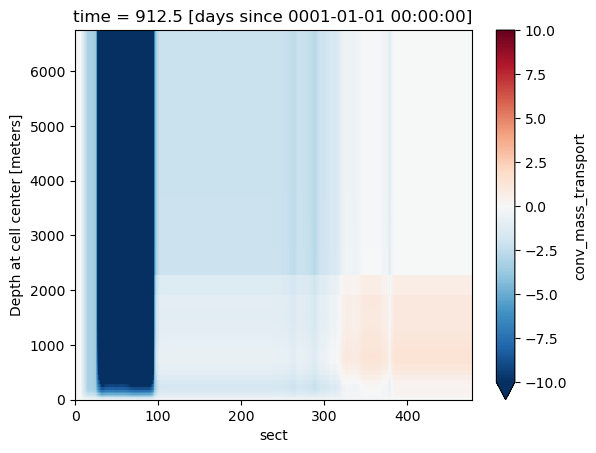

In [19]:
rho0 = 1035.
(Trp['conv_mass_transport'].isel(time=0).cumsum("sect").cumsum("z_l") / rho0*1e-6).plot(cmap="RdBu_r", vmin=-10, vmax=10)

## Diagnosing overturning streamfunctions in depth and density space

In [20]:
names_z = {'x_center': 'sect',
         'layer': 'z_l',
         'interface': 'z_i'}

names_rho2 = {'x_center': 'sect',
              'layer': 'rho2_l',
              'interface': 'rho2_i'}

In [21]:
ovt = xoverturning.compfunc.compute_streamfunction(Trp, names_z, transport='conv_mass_transport', fromtop=True)

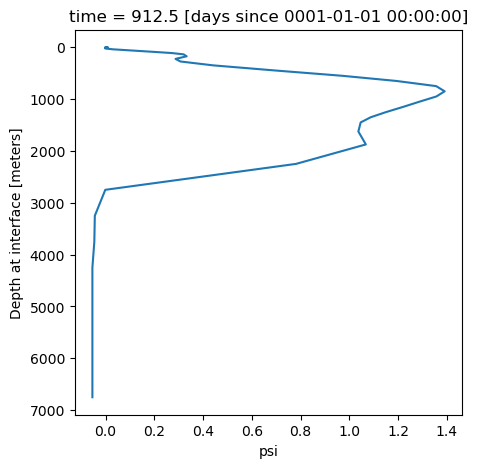

In [22]:
ovt.isel(time=0).plot(y='z_i', yincrease=False, figsize=[5,5])

In [ ]:
ds_rho2 = xr.open_mfdataset(f"{dir_pp}/ocean_annual_rho2_d2/av/annual_5yr/*.nc", decode_times=False)

In [ ]:
ds_rho2

In [ ]:
Trp_rho2 = sectionate.convergent_transport(ds_rho2, grid, i, j, layer='rho2_l', interface='rho2_i', counterclockwise=True)

In [ ]:
(Trp_rho2['conv_mass_transport'].isel(time=0).cumsum("sect").cumsum("rho2_l") / rho0*1e-6).plot(cmap="RdBu_r", vmin=-10, vmax=10)
plt.ylim(1035, 1038)

In [ ]:
ovt_rho2 = xoverturning.compfunc.compute_streamfunction(Trp_rho2, names_rho2, transport='conv_mass_transport', fromtop=True)

In [ ]:
ovt_rho2.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1040,1030])

In [ ]:
Trp_rho2 = sectionate.convergent_transport(ds_rho2, grid, i, j, layer='rho2_l', interface='rho2_i', counterclockwise=True)

In [ ]:
ovt_rho2 = xoverturning.compfunc.compute_streamfunction(Trp_rho2, names_rho2, transport='conv_mass_transport', fromtop=True)

In [ ]:
ovt_rho2.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1038,1034])

In [ ]:
np.isclose(ovt.isel(time=0).isel(z_i=-1).compute(), ovt_rho2.isel(time=0).isel(rho2_i=-1).compute(), rtol=1.e-4)